In [1]:
import pandas as pd


file_list = [
    
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_1_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_2_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_3_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_4_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_5_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_6_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_7_7.csv'
]

# 从CSV文件读取数据，并将日期列转换为datetime类型
df_list = [pd.read_csv(f, parse_dates=["IncorporationDate"]) for f in file_list]

# 合并所有数据框为一个大的数据框
df = pd.concat(df_list, ignore_index=True)
df.dropna(subset=['lat', 'long'], inplace=True)

# Save the processed dataframe to a new CSV file
#output_file_path = "/Users/rainfow/Desktop/Summer projects/companies_data/used_companies_data.csv"
#df.to_csv(output_file_path, index=False)


In [2]:
def filter_by_postcode_prefix(df, prefix):
    # Split the postcode at the space to get the prefix
    df['PostCodePrefix'] = df['RegAddress.PostCode'].str.split().str[0]
    # Filter the DataFrame based on the prefix
    df_filtered = df[df['PostCodePrefix'].str.startswith(prefix)]
    return df_filtered

df_filtered = filter_by_postcode_prefix(df, 'WC2')
df_filtered.head()

,CompanyName,RegAddress.PostCode,lat,long,CompanyCategory,IncorporationDate,SICCode.SicText_1,PostCodePrefix
5,!NFOGENIE LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2021-07-21,58290 - Other software publishing,WC2H
213,& PLAY LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2023-03-30,62012 - Business and domestic software develop...,WC2H
274,&LLOYD LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2023-01-26,70229 - Management consultancy activities othe...,WC2H
281,&OFFICES CANARY WHARF LIMITED,WC2N 6JU,51.508769,-0.122941,Private Limited Company,2011-12-14,68320 - Management of real estate on a fee or ...,WC2N
283,&OFFICES VICTORIA LIMITED,WC2N 6JU,51.508769,-0.122941,Private Limited Company,2004-03-23,68209 - Other letting and operating of own or ...,WC2N


In [3]:
import numpy as np

#df_filtered['Date'] = df_filtered['IncorporationDate'].dt.to_period('D')
df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


##df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().reset_index(name='CompanyCount')
##print(df_filtered_count.head(50))

df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).agg({
    'CompanyName': lambda x: list(x),
    'lat': 'first',
    'long': 'first',
    'SICCode.SicText_1': lambda x: list(x),
}).reset_index()

# df_filtered_count['CompanyCount'] = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().values

df_filtered_count.head()


/var/folders/00/r2pslk7j4k158048921m90wm0000gn/T/ipykernel_71025/2322913796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1
0,WC2A 1AA,1994-07-15,[CITY OPTICIANS LIMITED],51.517941,-0.113959,[47789 - Other retail sale of new goods in spe...
1,WC2A 1AA,2023-03-06,[J&T GOODS LTD],51.517941,-0.113959,[46160 - Agents involved in the sale of textil...
2,WC2A 1AD,2021-11-17,[CYNAPPZ LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...
3,WC2A 1AD,2022-02-16,[LOVE TEAM LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...
4,WC2A 1AF,1960-04-13,[PB LTD],51.517907,-0.113471,[70100 - Activities of head offices]


In [4]:
from datetime import datetime

def calculate_scores(df_filtered_count):
    # Ensure 'Date' column is in datetime format
    df_filtered_count['Date'] = pd.to_datetime(df_filtered_count['Date'])

    # Calculate the company count per postcode and date
    company_count_per_postcode_and_date = df_filtered_count.groupby(['RegAddress.PostCode', 'Date']).apply(lambda group: len(group['CompanyName'].explode()))

    # Define a function to calculate the density score
    def calculate_density_score(group):
        count = len(group['CompanyName'].explode())
        if count < 10:
            return 0
        elif count < 50:
            return 1
        elif count < 100:
            return 2
        else:
            return 3

    # Calculate the density score for each postcode
    density_score = df_filtered_count.groupby('RegAddress.PostCode').apply(calculate_density_score)

    # Define the cutoff date
    cutoff_date = datetime.strptime('2023-05-01', '%Y-%m-%d')

    # Define a function to calculate the last registration score
    def Last_Registration_score(date):
        years = (cutoff_date - date).days / 365
        if years > 10:
            return 0
        elif years > 3:
            return 1
        elif years > 1:
            return 2
        else:
            return 3

    # Calculate the date of the last company registration per postcode
    last_registration_date_per_postcode = df_filtered_count.groupby('RegAddress.PostCode')['Date'].max()

    # Calculate the last registration score for each postcode
    last_registration_score = last_registration_date_per_postcode.apply(Last_Registration_score)

    # Define a function to calculate the registration span score
    def Registration_Span_Score(group):
        span = (group.max() - group.min()).days / 365
        if span == 0 or span > 20:
            return 0
        elif span > 6:
            return 1
        elif span > 1:
            return 2
        else:
            return 3

    # Calculate the registration span score for each postcode
    registration_span_score = df_filtered_count.groupby('RegAddress.PostCode')['Date'].apply(Registration_Span_Score)

    # Define a function to calculate the frequency score
    def calculate_frequency_score(group):
        max_count = group.max()
        if max_count < 3:
            return 0
        elif max_count < 5:
            return 1
        elif max_count < 10:
            return 2
        else:
            return 3

    # Calculate the frequency score for each postcode
    frequency_score = company_count_per_postcode_and_date.groupby('RegAddress.PostCode').apply(calculate_frequency_score)

    # Create a new dataframe to hold the scores
    df_scores = df_filtered_count.copy()
    df_scores['CompanyCount'] = df_scores.set_index(['RegAddress.PostCode', 'Date']).index.map(company_count_per_postcode_and_date)
    df_scores['Density_Score'] = df_scores['RegAddress.PostCode'].map(density_score)
    df_scores['LastRegistration_Score'] = df_scores['RegAddress.PostCode'].map(last_registration_score)
    df_scores['RegistrationSpan_Score'] = df_scores['RegAddress.PostCode'].map(registration_span_score)
    df_scores['Frequency_Score'] = df_scores['RegAddress.PostCode'].map(frequency_score)

    return df_scores

# Test the function
df_filtered_scores = calculate_scores(df_filtered_count)
df_filtered_scores.head()


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1,CompanyCount,Density_Score,LastRegistration_Score,RegistrationSpan_Score,Frequency_Score
0,WC2A 1AA,1994-07-15,[CITY OPTICIANS LIMITED],51.517941,-0.113959,[47789 - Other retail sale of new goods in spe...,1,0,3,0,0
1,WC2A 1AA,2023-03-06,[J&T GOODS LTD],51.517941,-0.113959,[46160 - Agents involved in the sale of textil...,1,0,3,0,0
2,WC2A 1AD,2021-11-17,[CYNAPPZ LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...,1,0,2,3,0
3,WC2A 1AD,2022-02-16,[LOVE TEAM LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...,1,0,2,3,0
4,WC2A 1AF,1960-04-13,[PB LTD],51.517907,-0.113471,[70100 - Activities of head offices],1,1,1,0,1


In [5]:
# Calculate the sum of all scores for each postcode directly in the df_filtered_scores dataframe
df_filtered_scores['SumScores'] = df_filtered_scores[['Density_Score', 'LastRegistration_Score', 'RegistrationSpan_Score', 'Frequency_Score']].sum(axis=1)

# Group by postcode and calculate the max of sum of scores for each postcode
df_scores_sum = df_filtered_scores.groupby('RegAddress.PostCode').agg(
    lat=('lat', 'first'),  # Use the first latitude value for each postcode
    long=('long', 'first'),  # Use the first longitude value for each postcode
    TotalCompany=('CompanyName', 'size'),  # Count the total number of companies
    SumScores=('SumScores', 'max')  # Calculate the max of sum of scores
)

df_scores_sum_reset = df_scores_sum.reset_index()
df_scores_sum_reset


,RegAddress.PostCode,lat,long,TotalCompany,SumScores
0,WC2A 1AA,51.517941,-0.113959,2,3
1,WC2A 1AD,51.518087,-0.113928,2,5
2,WC2A 1AF,51.517907,-0.113471,28,3
3,WC2A 1AH,51.517642,-0.112127,2,5
4,WC2A 1AL,51.517348,-0.111721,102,6
...,...,...,...,...,...
709,WC2R 3JF,51.512870,-0.112886,41,3
710,WC2R 3JJ,51.513140,-0.112846,2,3
711,WC2R 3LA,51.511996,-0.113326,61,4
712,WC2R 3LD,51.512687,-0.113084,3,2


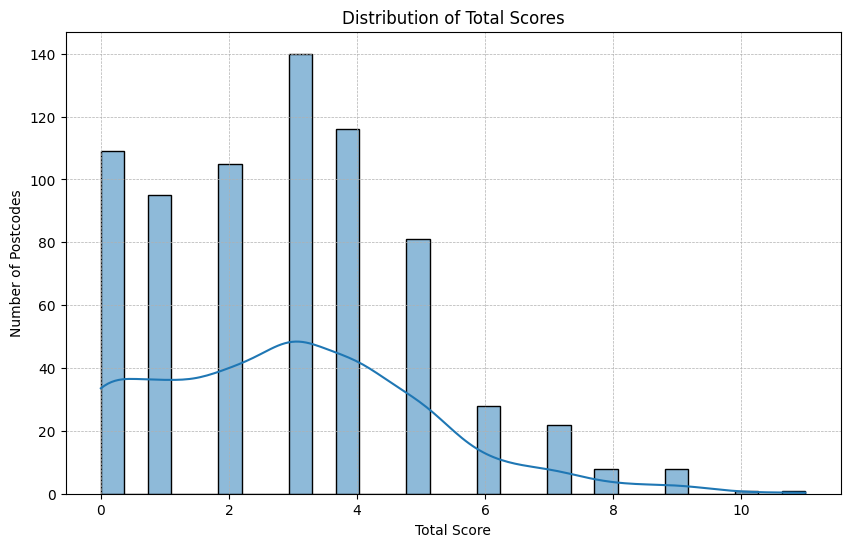

count    714.000000
mean       2.903361
std        2.086601
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: SumScores, dtype: float64

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical description of Total_Score
score_description = df_scores_sum_reset["SumScores"].describe()

# Plot the histogram for Total_Score
plt.figure(figsize=(10,6))
sns.histplot(df_scores_sum_reset["SumScores"], kde=True, bins=30)
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Number of Postcodes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

score_description


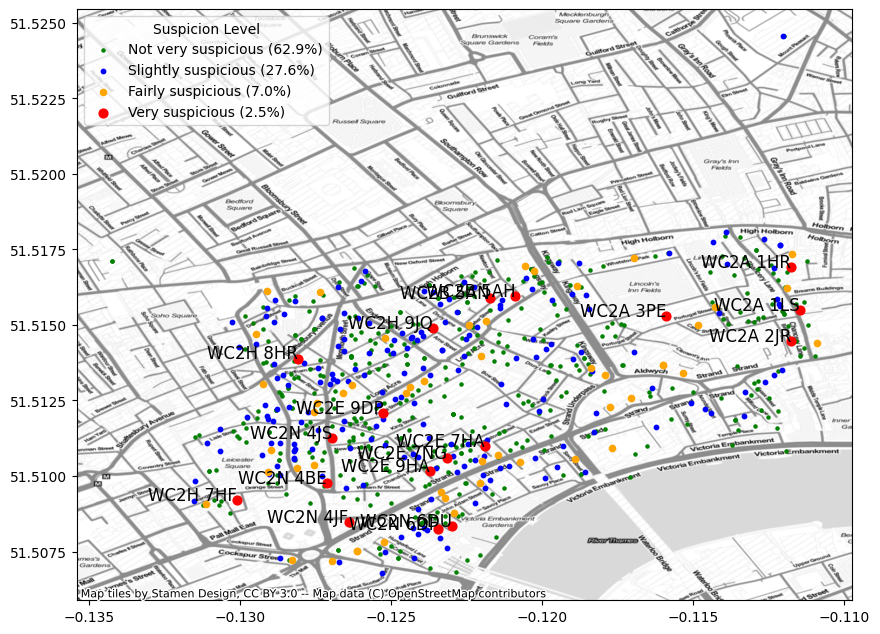

In [17]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))


# Define the color and size mapping based on the quantiles of 'SumScores'
def map_color_size(score):

    threshold_1 = 5
    threshold_2 = 7

    if score <= df_scores_sum_reset['SumScores'].quantile(0.5):
        return 'green', 5, 'Not very suspicious'
    elif score <= threshold_1:
        return 'blue', 10, 'Slightly suspicious'
    elif score <= threshold_2:
        return 'orange', 20, 'Fairly suspicious'
    else:
        return 'red', 40, 'Very suspicious'

df_scores_sum_reset['color'], df_scores_sum_reset['size'], df_scores_sum_reset['label'] = zip(*df_scores_sum_reset['SumScores'].apply(map_color_size))

# Calculate the total number of postcodes
total_postcodes = len(df_scores_sum_reset)

# Define a dictionary for labels, colors, and sizes
label_dict = {
    'Not very suspicious': {'color': 'green', 'size': 5},
    'Slightly suspicious': {'color': 'blue', 'size': 10},
    'Fairly suspicious': {'color': 'orange', 'size': 20},
    'Very suspicious': {'color': 'red', 'size': 40}
}

# Scatter plot
for label, attr in label_dict.items():
    idx = df_scores_sum_reset['label'] == label
    postcode_count = len(df_scores_sum_reset.loc[idx])
    percentage = postcode_count / total_postcodes * 100
    ax.scatter(df_scores_sum_reset.loc[idx, 'long'], df_scores_sum_reset.loc[idx, 'lat'], c=attr['color'], s=attr['size'], label=f'{label} ({percentage:.1f}%)')

    # If the label is "Very suspicious" (which corresponds to red), add the postal code text
    if label == "Very suspicious":
       for x, y, postcode in zip(df_scores_sum_reset.loc[idx, 'long'], df_scores_sum_reset.loc[idx, 'lat'], df_scores_sum_reset.loc[idx, 'RegAddress.PostCode']):
          ax.text(x, y, postcode, ha='right', fontsize=12, color='black')


# Add legend
ax.legend(title="Suspicion Level")

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()
